In [232]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from numpy import zeros_like
from IPython.display import display
def display_matrix(m):
    display(sympy.Matrix(m))
import sympy
import pandas as pd
import scipy.stats as ss

sympy.init_printing()

In [233]:
N = 4  # number of time steps
r = 0.06  # interest rate
K = 0.7 # strike
T = 3  # Maturity

dt = T / (N - 1)  # time interval
df = np.exp(-r * dt)  # discount factor per time interval

In [234]:
S = np.array(
    [
        [1.00, 1.09, 1.08, 1.34],
        [1.00, 1.16, 1.26, 1.54],
        [1.00, 1.22, 1.07, 1.52],
        [1.00, 0.93, 0.97, 0.92],
        [1.00, 1.11, 1.56, 1.52],
        [1.00, 0.76, 0.77, 0.90],
        [1.00, 0.92, 0.84, 1.01],
        [1.00, 0.88, 1.22, 1.34],
    ]
)

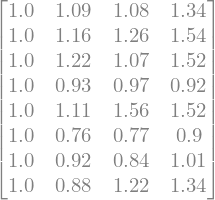

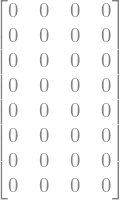

In [235]:
display_matrix(S)
H = np.maximum(K - S, 0)
display_matrix(H)

0.025487193947063665

In [236]:
def merton_jump_paths(S0, T, r, sigma,  lam, m, v, steps, Npaths):
    size=(steps,Npaths)
    dt = T/steps 
    poi_rv = np.multiply(np.random.poisson( lam*dt, size=size), np.random.normal(m,v, size=size)).cumsum(axis=0)
    geo = np.cumsum(((r -  sigma**2/2 -lam*(m  + v**2*0.5))*dt + sigma*np.sqrt(dt) * np.random.normal(size=size)), axis=0)
    return np.exp(geo+poi_rv)*S0

def merton_jump_to_ruin_paths(S0, T, r, sigma, lam, steps, Npaths):
    size = (steps, Npaths)
    dt = T/steps
    jump_indices = np.random.poisson(lam*dt, size=size)
    ruin_indices = np.cumsum(jump_indices, axis=0) > 0  # Identify points after the jump

    # Geometric Brownian Motion component
    geo = np.cumsum((r - sigma**2/2)*dt + sigma*np.sqrt(dt) * np.random.normal(size=size), axis=0)

    # Combine and apply the ruin effect
    stock_paths = np.exp(geo)*S0
    stock_paths[ruin_indices] = 0  # Set to zero after the jump
    return stock_paths

In [237]:
def merton_jump_paths(S0, paths, lam, sigma, mu, v, m, T, I):
    np.random.seed(42)
    df = np.exp(-mu*T)
    matrix = np.zeros((paths, I))
    for k in range(paths):
        X = np.zeros(I)
        S = np.zeros(I)
        
        X[0] = np.log(S0)
        S[0] = S0
        dt = T / I
    
        for i in range(1,I):
            Z = np.random.standard_normal()
            N = np.random.poisson(lam * dt)
            Y = np.exp(np.random.normal(m,v,N))
    
            if N == 0:
                M = 0
    
            else:
                for j in range(N):
                    M = np.sum(np.log(Y))
                    
            X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z + M
            S[i] = np.exp(X[i])
        matrix[k] = S
    return matrix


# drop model

def merton_jump_to_ruin_paths(S0, paths, lam, sigma, mu, v, m, T, I):
    np.random.seed(42)
    df = np.exp(-mu*T)
    matrix = np.zeros((paths, I))
    for k in range(paths):
        X = np.zeros(I)
        S = np.zeros(I)

        X[0] = np.log(S0)
        S[0] = S0
        dt = T / I
    
        for i in range(1,I):
            Z = np.random.standard_normal()
            N = np.random.poisson(lam * dt)
            Y = np.exp(np.random.normal(m,v,N))
    
            if N == 0 and X[i-1] > 0:
                X[i] = X[i-1] + (mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z
                S[i] = np.exp(X[i])
            else:
                S[i] = 0
        matrix[k] = S
    return matrix

In [238]:
N = 4  # number of time steps
r = 0.06  # interest rate
K = 0.7 # strike
T = 1  # Maturity

sigma = 0.5

dt = T / (N - 1)  # time interval
df = np.exp(-r * dt)  # discount factor per time interval

In [239]:
mu = 0.06
r = 0.06
T = 1
I = 250
paths = 1000
m = 0
K = 97

GBM_lam = 0
GBM_sigma = 0.04
GBM_mu = r
GBM_v = 0

LN_lam = 1
LN_sigma = 0.02
LN_mu = r
LN_v = 0.02

JR_lam = 0.01
JR_sigma = 0.03
JR_mu = r + JR_lam

df = np.exp(-mu*T)

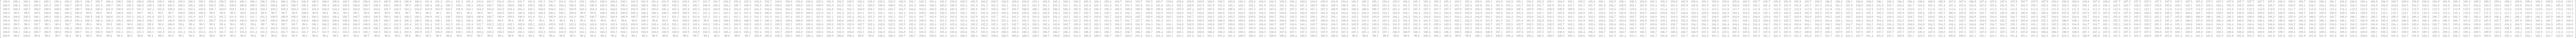

In [240]:
#S = merton_jump_paths(1, 10, 0.05, sigma, 0.1, 0.2, 0.1, 1, 10)
S = merton_jump_to_ruin_paths(100, 10, JR_lam, JR_sigma, JR_mu, 0, 0, 1, 250)
display_matrix(S.round(1))

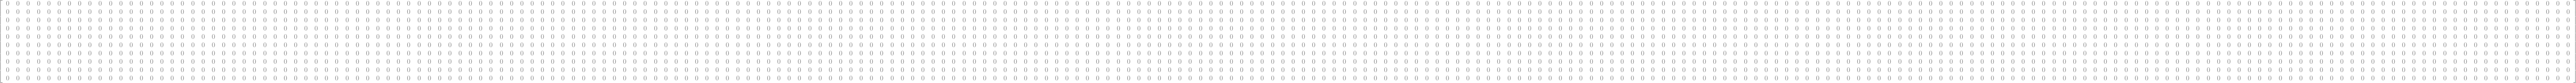

In [241]:
H = np.maximum(K - S, 0)
display_matrix(H.round(2))

In [242]:
good_paths = H[:, ] > 0
good_paths

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [243]:
#H = np.maximum(K - S, 0)  # intrinsic values for put option
#V = np.zeros_like(H)  # value matrix
#V[:, -1] = H[:, -1] # set value at maturity equal to intrinsic value
## Valuation by LS Method
#for t in range(N - 2, 0, -1): #start at t = I-2 and go backwards (since we already set t = I-1 to intrinsic value)
#    good_paths = H[:, t] > 0  # paths where the intrinsic value is positive
#    # the regression is performed only on these paths
#    rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, 3)  # polynomial regression
#    C = np.polyval(rg, S[good_paths, t])  # evaluation of regression
#
#    exercise = np.zeros(len(good_paths), dtype=bool)  # initialize
#    exercise[good_paths] = H[good_paths, t] > C  # paths where it is optimal to exercise
#
#    V[exercise, t] = H[exercise, t]  # set V equal to H where it is optimal to exercise
#    V[exercise, t + 1 :] = 0  # set future cash flows, for that path, equal to zero
#    discount_path = V[:, t] == 0  # paths where we didn't exercise
#    V[discount_path, t] = V[discount_path, t + 1] * df  # set V[t] in continuation region
#
#V0 = np.mean(V[:, 1]) * df  # discounted expectation of V[t=1]
#print('The value of the American put option is: ', V0)
#

In [244]:
import numpy as np

# Assuming you have defined N, S, H, df, K, and other necessary parameters

V = np.zeros_like(H)  # value matrix
V[:, -1] = H[:, -1]

# Valuation by LS Method
for t in range(N - 2, 0, -1):
    good_paths = H[:, t] > 0  # paths where the intrinsic value is positive

    if np.sum(good_paths) > 0:
        # Perform regression only on paths with positive intrinsic value
        rg = np.polynomial.legendre.legfit(S[good_paths, t], V[good_paths, t + 1] * df, 2)
        C = np.polynomial.legendre.legval(S[good_paths, t], rg)

        exercise = np.zeros(len(good_paths), dtype=bool)
        exercise[good_paths] = H[good_paths, t] > C

        V[exercise, t] = H[exercise, t]
        V[exercise, t + 1 :] = 0
    else:
        # Skip regression but still update continuation values
        exercise = np.zeros(len(good_paths), dtype=bool)

    # Update continuation values
    discount_path = ~exercise
    V[discount_path, t] = V[discount_path, t + 1] * df

V0 = np.mean(V[:, 1]) * df
print("Example price= ", V0)


Example price=  0.0


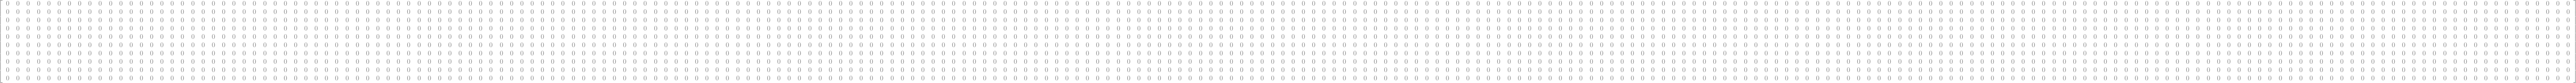

In [245]:
display_matrix(V.round(3))